<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<div style="font-size: 1.5em; font-weight: bold;">A2: Model Development in Python - TEAM 9</div>
<div style="font-size: 1.2em;">BCH-7812 | Business Challenge II</div>
Chase Kusterer, Priyanka Shrivastava - Faculty of Analytics<br>
Hult International Business School<br>

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

### Model Introduction
The present project aims to develop a predictive model capable of forecasting the number of clicks for the digital marketing campaigns conducted by Air France Airlines. The primary focus was on utilizing data from the 'Keyword' column, which represents the specific terms used in each campaign. The goal was to understand the impact of keywords on campaign effectiveness, as measured by clicks, a crucial metric to optimize for the success of future campaigns. Various regression models from the sklearn library were explored to find the most accurate and reliable predictor. During the data cleaning, modeling, and transformation process, techniques such as TF-IDF for text data transformation were employed, along with exploratory data analysis (EDA) to uncover patterns and relationships. Feature engineering was also conducted to enhance the model's performance. The analysis aimed to balance the model's complexity with interpretability and generalization to unseen data

<br>

 <h2> Part I: Imports and Data Check</h2>
 

In [1243]:
## importing libraries ##
import numpy             as np                       # mathematical essentials
import pandas            as pd                       # data science essentials
import sklearn.linear_model                          # linear models
from sklearn.model_selection import train_test_split # train/test split

#!###############################!#
#!# import additional libraries #!#
#!###############################!#
#_____
import seaborn as sns # enhanced graphical output
import matplotlib.pyplot as plt # essential graphical output
import statsmodels.formula.api as smf # regression modeling
from scipy.stats import boxcox
from scipy import stats
from scipy.stats import yeojohnson
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsRegressor # KNN for Regression
from sklearn.preprocessing import StandardScaler  # standard scaler
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor         # regression trees
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import plot_tree     
from sklearn.model_selection import RandomizedSearchCV # hyperparameter tuning
from sklearn.model_selection import cross_val_score

# setting pandas print options (optional)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [1124]:
## importing data ##

# reading modeling data into Python
modeling_data = './datasets/train.csv'

# calling this df_train
df_train = pd.read_csv(filepath_or_buffer = modeling_data,
                         header           = 0,
                         index_col        = 'entry_id')



# reading testing data into Python
testing_data = './datasets/test.csv'

# calling this df_test
df_test = pd.read_csv(filepath_or_buffer = testing_data,
                         header           = 0,
                         index_col        = 'entry_id')

In [1125]:
# concatenating datasets together for mv analysis and feature engineering
df_train['set'] = 'Not Kaggle'
df_test ['set'] = 'Kaggle'

# concatenating both datasets together for mv and feature engineering
df_full = pd.concat(objs = [df_train, df_test],
                    axis = 0,
                    ignore_index = False)


# checking data
df_full.head(n = 5)

,Publisher Name,Keyword,Match Type,Campaign,Keyword Group,Category,Bid Strategy,Status,Search Engine Bid,Impressions,Avg. Pos.,Avg. Cost per Click,Clicks,set
entry_id,,,,,,,,,,,,,,
mkt_001,Google - Global,fly to nice,Broad,Air France Global Campaign,Nice,nice,Position 1- 3,Unavailable,$1.25,380,1.85,$0.95,15,Not Kaggle
mkt_002,Yahoo - US,munich airport,Advanced,Western Europe Destinations,Munich,uncategorized,NaN,Paused,$6.25,25,1.84,$5.71,1,Not Kaggle
mkt_003,Overture - Global,chicago to paris,Advanced,Unassigned,Unassigned,paris,Position 1-2 Target,Sent,$0.45,"2,315",4.48,$0.43,14,Not Kaggle
mkt_005,Yahoo - US,discount international airfare,Advanced,Geo Targeted Los Angeles,Discount International Los Angeles,uncategorized,NaN,Paused,$6.25,86,1.42,$2.45,9,Not Kaggle
mkt_006,Google - US,cont:google_yearlong 2006::google|marrakech,NaN,Google_Yearlong 2006,Google|marrakech,uncategorized,NaN,Unavailable,$7.50,19,1.53,$4.63,1,Not Kaggle


In [1126]:
df_full = df_full.rename(columns={
    'Publisher Name': 'Publisher_Name',
    'Keyword': 'Keyword',
    'Match Type': 'Match_Type',
    'Campaign': 'Campaign',
    'Keyword Group': 'Keyword_Group',
    'Category': 'Category',
    'Bid Strategy': 'Bid_Strategy',
    'Status': 'Status',
    'Search Engine Bid': 'Search_Engine_Bid',
    'Impressions': 'Impressions',
    'Avg. Pos.': 'Avg_Pos',
    'Avg. Cost per Click': 'Avg_Cost_per_Click',
    'Clicks': 'Clicks',
    'set': 'set'
})

In [1127]:
# checking available features
df_full.columns

Index(['Publisher_Name', 'Keyword', 'Match_Type', 'Campaign', 'Keyword_Group', 'Category', 'Bid_Strategy', 'Status', 'Search_Engine_Bid', 'Impressions', 'Avg_Pos', 'Avg_Cost_per_Click', 'Clicks', 'set'], dtype='object')

In [1128]:
#!##############################!#
#!# set your response variable #!#
#!##############################!#
y_variable = 'Clicks'
df_full_mv = df_full

<br><hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h2>Part II: Data Preparation</h2>
<br>

## Base Modeling ##



## Critical Insights from EDA, Data Preprocessing, and Feature Engineering

1. The exploratory data analysis revealed that the 'Clicks' column had a highly skewed distribution with a significant concentration of low values, suggesting that many campaigns achieve minimal engagement with their target audience. Therefore, a logarithmic transformation was applied to 'Clicks', creating 'log_Clicks', which allowed us to normalize the distribution and improve the model's performance. Additionally, we experimented with the Yeo-Johnson transformation, generating the variable 'YeoJohnson_Clicks', which further improved the distribution normalization.

2. Cleaning the 'Search Engine Bid' and 'Impressions' columns was important, despite not having null values, as non-numeric characters were removed to enable the treatment of these numerical data.

3. TF-IDF was applied to the 'Keyword' column due to the need for text handling, highlighting the variable importance of specific keywords in predicting 'Clicks'.

4. After applying TF-IDF, we encountered a high-dimensional dataset, leading us to prioritize variables with the greatest impact on the model, as well as grouping categories with low recurrence in the dataset. For variable prioritization, we used tree-based models for feature selection.

5. The categorical variables 'Category' and 'Keyword Group' were transformed using mean encoding based on the 'Clicks' column, providing a numerical representation capturing the impact of the categories on the target variable.

6. Concatenating the cleaned and engineered features from both training and test sets into a single dataframe called df_full facilitated attribute manipulation, allowing for simplified modeling and saving reprocessing time, while maintaining consistent feature engineering throughout the database.

7. Certain features such as 'Clicks', 'log_Clicks', and 'YeoJohnson_Clicks' were strategically excluded from the model to avoid data leakage and ensure the model's predictive capacity, focusing on non-collinearity or redundant informative features.

8. In handling missing values, especially in the 'Bid Strategy' column, we sought to find a relationship with the other columns to identify a trend that would allow us to complete the missing values. Continuing with 'Bid Strategy', assignment rules were established with other columns such as 'Publisher_Name', 'Campaign', 'Category', and 'Status'. This optimized the behavior of that variable, as it had many null values.

## Top Three Data Visualizations

1. The visualization of the correlation matrix using a heatmap was relevant for detecting the variables that could help predict the target variable 'Clicks', as it allowed us to see in a single image the coefficients of correlation of greater and lesser intensity. It's worth noting that it was also useful to visualize the correlations between other variables, such as 'Search Engine Bid' and 'Avg Pos'.

2. The boxplot visualization of the 'Avg_Cost_per_click' variable with respect to the categorical variable 'Bid Strategy' was important for disproving the hypothesis that a strategy aiming to appear among the top search results is more expensive than appearing on pages 3 and beyond of online search engines. This is false, as we can see that even the 'position 3-6' strategy has the highest average cost per click.

3. The visualization of the distribution of the 'Clicks' column, as well as the visualization of the distribution of the 'log_Clicks' and 'YeoJohnson_Clicks' columns, allowed us to have a clear idea of their behavior and what transformation could be done to increase symmetry. As we know, increasing symmetry improves predictive capability. Thus, 'log_Clicks' significantly improves the lack of symmetry of 'Clicks', but the distribution of 'YeoJohnson_Clicks' manages to be even more bell-shaped.

In [1130]:
# Data cleaning: Convert 'Search Engine Bid', 'Avg. Cost per Click', 'Clicks', and 'Impressions' to numeric

# Remove '$' and ',' then convert to numeric
df_full['Search_Engine_Bid'] = pd.to_numeric(df_full['Search_Engine_Bid'].str.replace('[\$,]', '', regex=True), errors='coerce')
df_full['Avg_Cost_per_Click'] = pd.to_numeric(df_full['Avg_Cost_per_Click'].str.replace('[\$,]', '', regex=True), errors='coerce')
df_full['Clicks'] = pd.to_numeric(df_full['Clicks'].str.replace(',', ''), errors='coerce')
df_full['Impressions'] = pd.to_numeric(df_full['Impressions'].str.replace(',', ''), errors='coerce')


In [1131]:
df_full.columns

Index(['Publisher_Name', 'Keyword', 'Match_Type', 'Campaign', 'Keyword_Group', 'Category', 'Bid_Strategy', 'Status', 'Search_Engine_Bid', 'Impressions', 'Avg_Pos', 'Avg_Cost_per_Click', 'Clicks', 'set'], dtype='object')

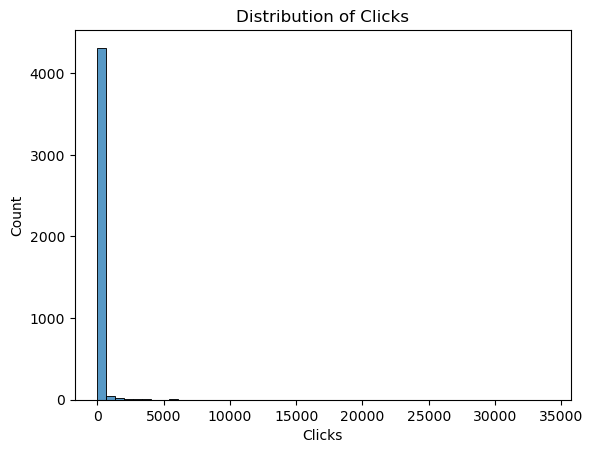

In [1132]:
# developing a histogram using HISTPLOT
sns.histplot(data  = df_full,
             x     = "Clicks",
             bins  = 50)


# title and axis labels
plt.title(label   = "Distribution of Clicks")
plt.xlabel(xlabel = "Clicks") # avoiding using dataset labels
plt.ylabel(ylabel = "Count")


# displaying the histogram
plt.show()

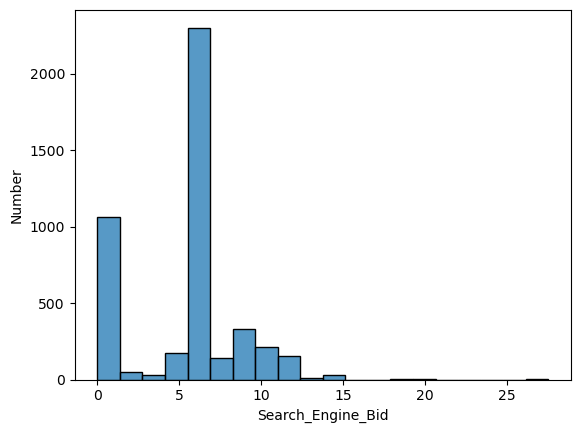

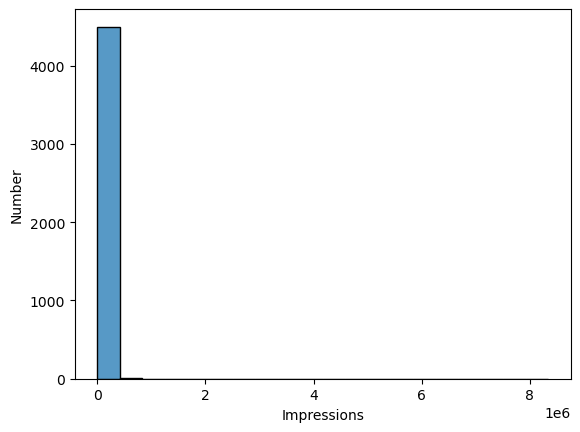

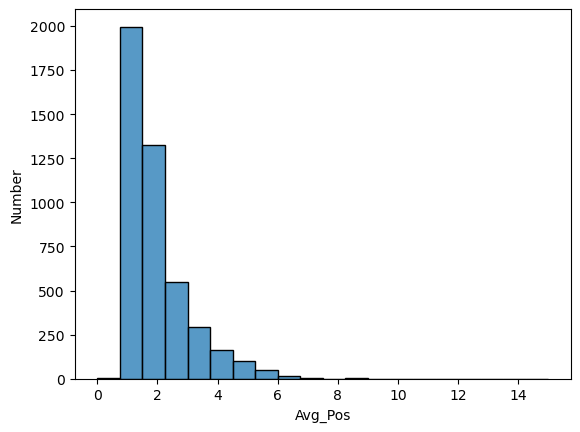

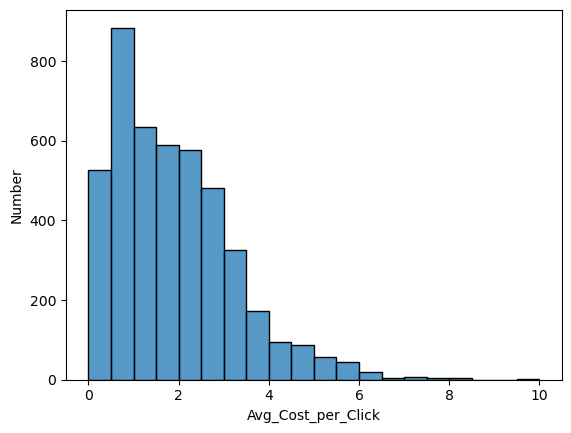

In [1133]:
inputs_num = ['Search_Engine_Bid', 'Impressions', 'Avg_Pos', 'Avg_Cost_per_Click']
num_bins = 20
data = df_full

for i in inputs_num:
    sns.histplot(x = data[i],
                 bins  = num_bins)
    plt.xlabel(i)
    plt.ylabel('Number')
    plt.show()

In [1134]:
# descriptive statistics for numeric data
df_full_stats = df_full.iloc[ :, 1: ].describe(include = 'number').round(decimals = 2)
df_full_stats

,Search_Engine_Bid,Impressions,Avg_Pos,Avg_Cost_per_Click,Clicks
count,4510.00,4510.00,4510.00,4510.00,4410.00
mean,5.43,9283.52,1.93,1.89,103.58
std,3.30,169667.42,1.08,1.32,1029.11
min,0.00,0.00,0.00,0.00,1.00
25%,3.39,28.00,1.14,0.83,1.00
50%,6.25,176.00,1.59,1.65,4.00
75%,6.25,843.50,2.31,2.66,18.00
max,27.50,8342415.00,15.00,10.00,34012.00


In [1135]:
# developing a correlation matrix
df_full_corr = df_full.corr(method = 'pearson',numeric_only = True)
df_full_corr

# filtering results to show correlations with Sale_Price
df_full_corr.loc[ : , "Clicks"].round(decimals = 2).sort_values(ascending = False)

Clicks                1.00
Impressions           0.40
Search_Engine_Bid     0.13
Avg_Pos              -0.02
Avg_Cost_per_Click   -0.03
Name: Clicks, dtype: float64

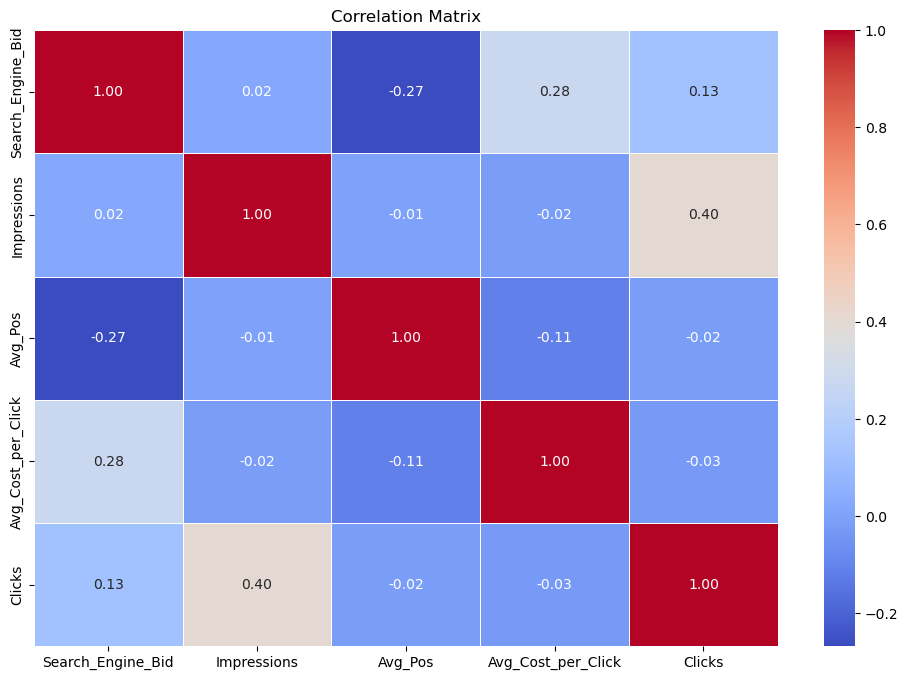

In [1136]:
# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_full_corr, 
            annot=True, fmt=".2f", 
            cmap='coolwarm', 
            cbar=True, 
            linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

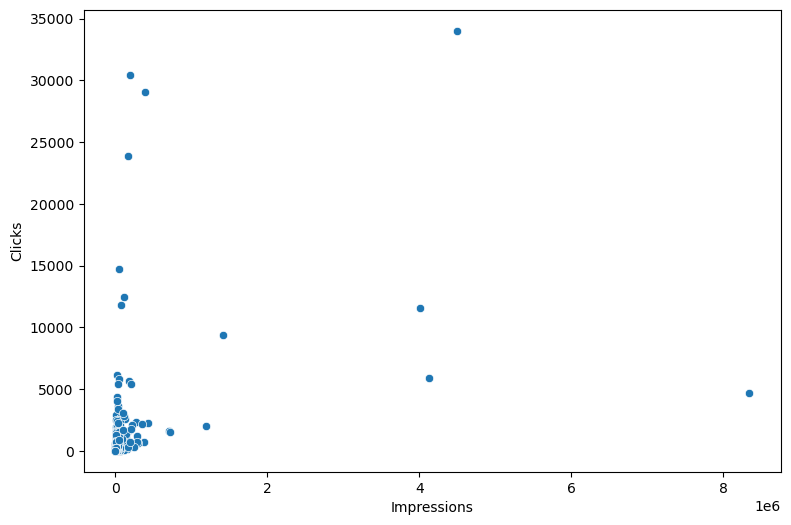

In [1137]:
# setting figure size
fig, ax = plt.subplots(figsize = (9, 6))


# developing a scatterplot
sns.scatterplot(x    = "Impressions",
         y    = "Clicks",
         data = df_full)


# SHOWing the results
plt.show()

<br><h3>Missing Value Analysis and Imputation</h3>

In [1138]:
## Missing Value Imputation ##
df_full.isnull().describe()
df_full.isnull().sum(axis = 0)

Publisher_Name           0
Keyword                  0
Match_Type              48
Campaign                 0
Keyword_Group            0
Category                 0
Bid_Strategy          1224
Status                   0
Search_Engine_Bid        0
Impressions              0
Avg_Pos                  0
Avg_Cost_per_Click       0
Clicks                 100
set                      0
dtype: int64

In [1139]:
df_full.isnull().mean(axis = 0)

Publisher_Name        0.000000
Keyword               0.000000
Match_Type            0.010643
Campaign              0.000000
Keyword_Group         0.000000
Category              0.000000
Bid_Strategy          0.271397
Status                0.000000
Search_Engine_Bid     0.000000
Impressions           0.000000
Avg_Pos               0.000000
Avg_Cost_per_Click    0.000000
Clicks                0.022173
set                   0.000000
dtype: float64

In [1140]:
# looping to flag features with missing values
for col in df_full:

    # creating columns with 1s if missing and 0 if not
    if df_full[col].isnull().astype(int).sum() > 0:
        df_full['m_'+col] = df_full[col].isnull().astype(int)

In [1141]:
df_full = df_full.drop(columns=['m_Clicks'])

Index(['Publisher_Name', 'Keyword', 'Match_Type', 'Campaign', 'Keyword_Group', 'Category', 'Bid_Strategy', 'Status', 'Search_Engine_Bid', 'Impressions', 'Avg_Pos', 'Avg_Cost_per_Click', 'Clicks', 'set', 'm_Match_Type', 'm_Bid_Strategy'], dtype='object')

In [1142]:
# checking results - summing missing value flags
df_full[ ['m_Match_Type', 'm_Bid_Strategy'] ].sum(axis = 0)

m_Match_Type        48
m_Bid_Strategy    1224
dtype: int64

In [1143]:
# subsetting for mv features
mv_flag_check = df_full[ ['Match_Type'     , 'm_Match_Type',
                          'Bid_Strategy' , 'm_Bid_Strategy'] ]


# checking results - feature comparison
mv_flag_check.sort_values(by = ['m_Match_Type', 'm_Bid_Strategy'],
                          ascending = False).head(n = 10)

,Match_Type,m_Match_Type,Bid_Strategy,m_Bid_Strategy
entry_id,,,,
mkt_006,NaN,1,NaN,1
mkt_043,NaN,1,NaN,1
mkt_1034,NaN,1,NaN,1
mkt_1101,NaN,1,NaN,1
mkt_1212,NaN,1,NaN,1
mkt_1340,NaN,1,NaN,1
mkt_1440,NaN,1,NaN,1
mkt_1493,NaN,1,NaN,1
mkt_1679,NaN,1,NaN,1


In [1144]:
#Let's check some descriptive details about this Categorical Data 
df_full[['Match_Type','Bid_Strategy']].describe(include = 'all').transpose()

,count,unique,top,freq
Match_Type,4462,4,Broad,2591
Bid_Strategy,3286,8,Position 5-10 Bid Strategy,2208


In [1145]:
#Let's see how is related the Match Type with the Type of Campaign and the Publisher Name we have been using
filtered_data = df_full[df_full['Match_Type'].isnull()]
filtered_data.groupby(['Publisher_Name','Campaign']).Clicks.count()

Publisher_Name   Campaign                  
Google - Global  Air France Global Campaign     7
Google - US      Geo Targeted Boston            0
                 Google_Yearlong 2006          37
Name: Clicks, dtype: int64

In [1146]:
#Now, we are going to filter just the Campaign and Publisher Namer that null values matched before
filtered_data_1 = df_full[(df_full['Publisher_Name'].isin(['Google - Global', 'Google - US'])) & (df_full['Campaign'].isin(['Air France Global Campaign', 'Google_Yearlong 2006']))]
filtered_data_1.groupby(['Match_Type', 'Publisher_Name', 'Campaign']).Clicks.count()
#As we can see, the Broad Match Type fits perfectly with the Publisher Name and Campaign of Match Type null values

Match_Type  Publisher_Name   Campaign                  
Broad       Google - Global  Air France Global Campaign    268
            Google - US      Google_Yearlong 2006          475
Exact       Google - Global  Air France Global Campaign      1
Name: Clicks, dtype: int64

In [1147]:
# imputing Match_Type
df_full['Match_Type'].fillna(value   = 'Broad',
                             inplace = True)

In [1148]:
#Check the correct imputation
df_full[ ['Match_Type', 'm_Match_Type'] ][df_full['m_Match_Type'] == 1].head(n = 10)

,Match_Type,m_Match_Type
entry_id,,
mkt_006,Broad,1
mkt_043,Broad,1
mkt_1034,Broad,1
mkt_1101,Broad,1
mkt_1212,Broad,1
mkt_1340,Broad,1
mkt_1440,Broad,1
mkt_1493,Broad,1
mkt_1679,Broad,1


In [1149]:
#Let's see the same behaviour with Bid Strategy, but first, we are going to clean some misspelling
df_full['Bid_Strategy'].value_counts()
#For instance, Position 1 -2 Target and Position 1-2 Target are the same, just a space of diff
#The same with Position 1-4 Bid Strategy and Postiion 1-4 Bid Strategy, that has double ii. 

Bid_Strategy
Position 5-10 Bid Strategy    2208
Position 2-5 Bid Strategy      333
Position 1-2 Target            274
Position 1- 3                  264
Position 1-4 Bid Strategy      111
Pos 3-6                         45
Postiion 1-4 Bid Strategy       40
Position 1 -2 Target            11
Name: count, dtype: int64

In [1150]:
# Defining a dictionary to map misspelled values to their corrected versions
corrections = {
    'Position 1 -2 Target': 'Position 1-2 Target',
    'Postiion 1-4 Bid Strategy': 'Position 1-4 Bid Strategy',
    'Position 1- 3': 'Position 1-3',
    'Pos 3-6': 'Position 3-6'
}

# Apply the corrections using the replace method
df_full['Bid_Strategy'] = df_full['Bid_Strategy'].replace(corrections)

# Verify the changes
print(df_full['Bid_Strategy'].value_counts())

Bid_Strategy
Position 5-10 Bid Strategy    2208
Position 2-5 Bid Strategy      333
Position 1-2 Target            285
Position 1-3                   264
Position 1-4 Bid Strategy      151
Position 3-6                    45
Name: count, dtype: int64


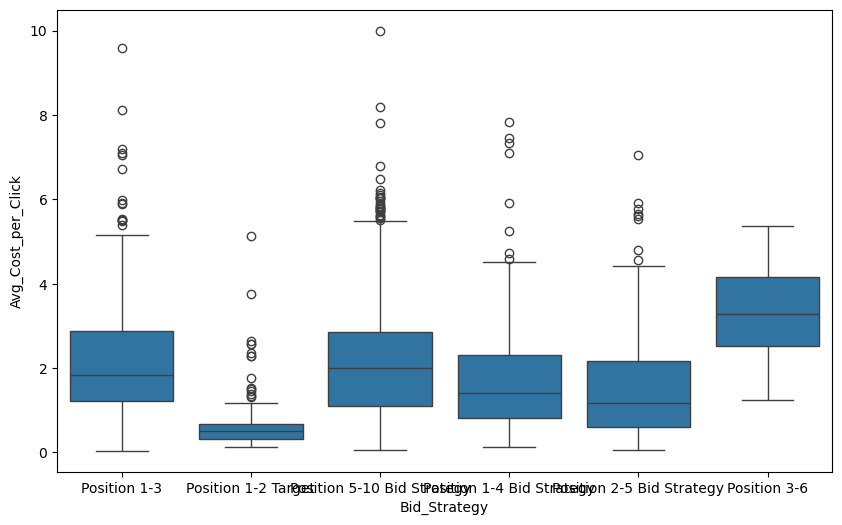

In [1151]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Bid_Strategy', y='Avg_Cost_per_Click', data=df_full)
plt.xlabel('Bid_Strategy')
plt.ylabel('Avg_Cost_per_Click')
plt.show()

In [1152]:
filtered_data_2 = df_full[df_full['Bid_Strategy'].isnull()]
filtered_data_2.groupby(['Publisher_Name','Campaign','Category','Status']).Clicks.count()

Publisher_Name     Campaign                                Category          Status     
Google - Global    Air France Brand & French Destinations  uncategorized     Paused          44
                                                                             Unavailable     61
                   Air France Global Campaign              uncategorized     Unavailable     18
Google - US        Air France Branded                      uncategorized     Live            18
                                                                             Paused           2
                   Geo Targeted Boston                     uncategorized     Unavailable      0
                   Geo Targeted New York                   uncategorized     Live             1
                   Google_Yearlong 2006                    uncategorized     Unavailable     37
                   Paris & France Terms                    uncategorized     Live             4
MSN - US           Air France Brand & French De

In [1153]:
filtered_data_3 = df_full[
    (df_full['Publisher_Name'].isin(['Google - Global','Google - US','MSN - US', 'Overture - Global','Overture - US','Yahoo - US'])) &
    (df_full['Campaign'].isin(['Air France Brand & French Destinations', 'Air France Global Campaign', 'Air France Branded', 'Geo Targeted Boston', 'Geo Targeted New York', 'Google_Yearlong 2006', 'Paris & France Terms', 'Business Class', 'Geo Targeted Seattle', 'Unassigned', 'French Destinations', 'Geo Targeted Atlanta', 'Geo Targeted Chicago', 'Geo Targeted Cincinnati', 'Geo Targeted DC', 'Geo Targeted Detroit', 'Geo Targeted Houston', 'Geo Targeted Los Angeles', 'Geo Targeted Miami', 'Geo Targeted Philadelphia', 'Geo Targeted San Francisco', 'Geo Targeted Boston', 'Western Europe Destinations'])) &
    (df_full['Category'].isin(['uncategorized','bordeaux','airfrance','vacation','tahiti','romantic','paris','nice','marseille','lyon','losangeles','houston','france','flight','ebsaleend7.28','airline','airfrancewebsite'])) &
    (df_full['Status'].isin(['Paused', 'Unavailable', 'Live','Sent']))
]

filtered_data_3.groupby(['Bid_Strategy', 'Publisher_Name', 'Campaign','Category','Status']).Clicks.count()

Bid_Strategy                Publisher_Name     Campaign                     Category          Status     
Position 1-2 Target         Google - US        Air France Branded           uncategorized     Live             9
                                                                                              Paused           1
                            Overture - Global  Unassigned                   airfrance         Paused          37
                                                                            airfrancewebsite  Paused           3
                                                                            airline           Paused           2
                                                                            bordeaux          Paused           4
                                                                            flight            Paused           9
                                                                            france            Sent     

In [1154]:
# Creating a dictionary with rules to replace null values in Bid_Strategy
replacement_dict = {
    ('Google - US', 'Air France Branded', 'uncategorized', 'Live'): 'Position 1-2 Target',
    ('Google - US', 'Air France Branded', 'uncategorized', 'Paused'): 'Position 1-2 Target',
    ('Overture - US','Unassigned','bordeaux','Paused'):'Position 1-4 Bid Strategy',
    ('Overture - US','Unassigned','flight','Unavailable'):'Position 1-4 Bid Strategy',
    ('Google - US','Business Class','uncategorized','Live'):'Position 2-5 Bid Strategy',
    ('Google - US','French Destinations','uncategorized','Live'):'Position 2-5 Bid Strategy',
    ('Google - US','French Destinations','uncategorized','Paused'):'Position 2-5 Bid Strategy',
    ('Google - US','Geo Targeted Seattle','uncategorized','Paused'):'Position 2-5 Bid Strategy',
    ('Google - US','Paris & France Terms','uncategorized','Live'):'Position 2-5 Bid Strategy',
    ('Overture - US','Unassigned','airfrance','Paused'):'Position 2-5 Bid Strategy',
    ('Overture - US','Unassigned','airfrance','Unavailable'):'Position 2-5 Bid Strategy',
    ('Overture - US','Unassigned','france','Paused'):'Position 2-5 Bid Strategy',
    ('Overture - US','Unassigned','lyon','Paused'):'Position 2-5 Bid Strategy',
    ('Overture - US','Unassigned','marseille','Paused'):'Position 2-5 Bid Strategy',
    ('Overture - US','Unassigned','nice','Paused'):'Position 2-5 Bid Strategy',
    ('Overture - US','Unassigned','paris','Paused'):'Position 2-5 Bid Strategy',
    ('Google - US','Paris & France Terms','uncategorized','Paused'):'Position 3-6',
    ('Google - US','Paris & France Terms','uncategorized','Unavailable'):'Position 3-6',
    'Google - Global': 'Position 1-3',
    'Overture - Global': 'Position 1-2 Target'
}
# imputing Bid_Strategy
for conditions, bid_strategy in replacement_dict.items():
    if isinstance(conditions, tuple):  # Si son condiciones detalladas
        df_full.loc[(df_full['Publisher_Name'] == conditions[0]) & 
                    (df_full['Campaign'] == conditions[1]) & 
                    (df_full['Category'] == conditions[2]) & 
                    (df_full['Status'] == conditions[3]) & 
                    (df_full['Bid_Strategy'].isnull()), 'Bid_Strategy'] = bid_strategy
    else:  # Si es un caso simplificado
        df_full.loc[df_full['Publisher_Name'] == conditions, 'Bid_Strategy'] = df_full['Bid_Strategy'].fillna(bid_strategy)



# Verificar el resultado
print(df_full['Bid_Strategy'].value_counts())


Bid_Strategy
Position 5-10 Bid Strategy    2208
Position 1-2 Target            589
Position 1-3                   393
Position 2-5 Bid Strategy      346
Position 1-4 Bid Strategy      155
Position 3-6                    45
Name: count, dtype: int64


In [1155]:
# imputing last Bid_Strategy null values
df_full['Bid_Strategy'].fillna(value   = 'Position 5-10 Bid Strategy',
                             inplace = True)

In [1156]:
#Check the correct imputation
df_full[ ['Bid_Strategy', 'm_Bid_Strategy'] ][df_full['m_Bid_Strategy'] == 1].head(n = 10)

,Bid_Strategy,m_Bid_Strategy
entry_id,,
mkt_002,Position 5-10 Bid Strategy,1
mkt_005,Position 5-10 Bid Strategy,1
mkt_006,Position 5-10 Bid Strategy,1
mkt_007,Position 1-2 Target,1
mkt_008,Position 5-10 Bid Strategy,1
mkt_010,Position 1-2 Target,1
mkt_020,Position 1-3,1
mkt_022,Position 5-10 Bid Strategy,1
mkt_029,Position 1-3,1


In [1157]:
# making sure all missing values have been taken care of
df_full.isnull().sum(axis = 0)

Publisher_Name          0
Keyword                 0
Match_Type              0
Campaign                0
Keyword_Group           0
Category                0
Bid_Strategy            0
Status                  0
Search_Engine_Bid       0
Impressions             0
Avg_Pos                 0
Avg_Cost_per_Click      0
Clicks                100
set                     0
m_Match_Type            0
m_Bid_Strategy          0
dtype: int64

<br><h3>Transformations</h3>

In [1158]:
# log transforming Clicks and saving it to the dataset
df_full['log_Clicks'] = np.log1p(df_full['Clicks'])

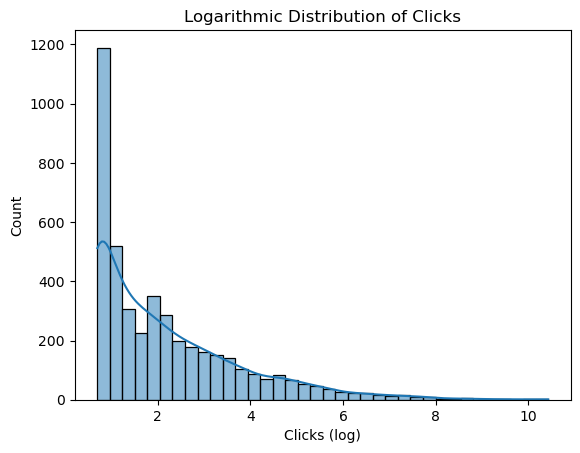

In [1159]:
# developing a histogram using HISTPLOT
sns.histplot(data   = df_full,
             x      = 'log_Clicks',
             kde    = True)


# title and axis labels
plt.title(label   = "Logarithmic Distribution of Clicks")
plt.xlabel(xlabel = "Clicks (log)") # avoiding using dataset labels
plt.ylabel(ylabel = "Count")

# displaying the histogram
plt.show()

In [1160]:
# Creating a mask to identify null values
mask = df_full['Clicks'].notna()

# Applying Yeo-Johnson transformation
transformed_data, _ = yeojohnson(df_full.loc[mask, 'Clicks'])
df_full.loc[mask, 'YeoJohnson_Clicks'] = transformed_data


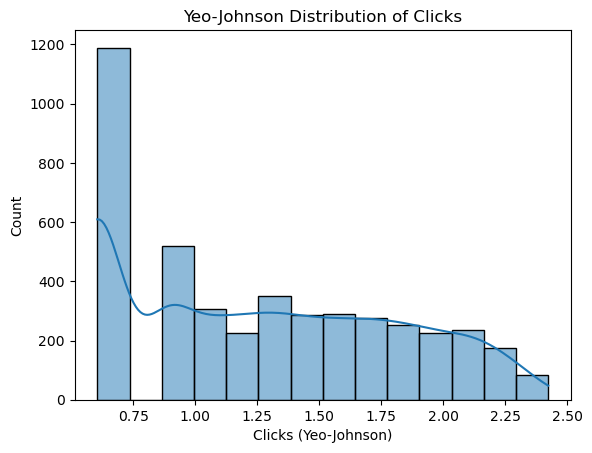

In [1161]:
# developing a histogram using HISTPLOT
sns.histplot(data   = df_full,
             x      = 'YeoJohnson_Clicks',
             kde    = True)


# title and axis labels
plt.title(label   = "Yeo-Johnson Distribution of Clicks")
plt.xlabel(xlabel = "Clicks (Yeo-Johnson)") # avoiding using dataset labels
plt.ylabel(ylabel = "Count")

# displaying the histogram
plt.show()

In [1162]:
#Checking skewness 
df_full.skew(axis = 0, numeric_only = True).round(decimals = 2)

Search_Engine_Bid      0.05
Impressions           36.75
Avg_Pos                2.07
Avg_Cost_per_Click     1.09
Clicks                23.98
m_Match_Type           9.54
m_Bid_Strategy         1.03
log_Clicks             1.43
YeoJohnson_Clicks      0.29
dtype: float64

In [1163]:
# Logarithmically transform any X-features that have an absolute skewness value greater than 1.0.

df_full['log_Impressions'] = np.log1p(df_full['Impressions'])
df_full['log_Avg_Pos'] = np.log1p(df_full['Avg_Pos'])
df_full['log_Avg_Cost_per_Click'] = np.log1p(df_full['Avg_Cost_per_Click'])

# Yeo-Johnson transform any X-features that have an absolute skewness value greater than 1.0.

df_full['YeoJohnson_Impressions'], _ = yeojohnson(df_full['Impressions'])
df_full['YeoJohnson_Avg_Pos'], _ = yeojohnson(df_full['Avg_Pos'])
df_full['YeoJohnson_Avg_Cost_per_Click'], _ = yeojohnson(df_full['Avg_Cost_per_Click'])

In [1164]:
min_positive_value = df_full[df_full['Impressions'] > 0]['Impressions'].min()
df_full['Impressions'] = df_full['Impressions'].replace(0, min_positive_value)
df_full['boxcox_Impressions'], fitted_lambda = stats.boxcox(df_full['Impressions'])

In [1165]:
# skewness AFTER logarithmic transformations
df_full.loc[ : , 'log_Clicks': ].skew(axis = 0).round(decimals = 2).sort_index(ascending = False)

log_Impressions                  0.31
log_Clicks                       1.43
log_Avg_Pos                      0.98
log_Avg_Cost_per_Click           0.08
boxcox_Impressions               0.00
YeoJohnson_Impressions           0.01
YeoJohnson_Clicks                0.29
YeoJohnson_Avg_Pos               0.03
YeoJohnson_Avg_Cost_per_Click    0.01
dtype: float64

In [1166]:
# analyzing (Pearson) correlations
df_corr = df_full.corr(method = 'pearson',numeric_only = True ).round(2)

df_corr.loc[ : , ['Clicks', 'log_Clicks','YeoJohnson_Clicks'] ].sort_values(by = 'Clicks',
                                                                ascending = False)

,Clicks,log_Clicks,YeoJohnson_Clicks
Clicks,1.00,0.36,0.19
Impressions,0.40,0.19,0.10
log_Clicks,0.36,1.00,0.94
log_Impressions,0.24,0.80,0.80
YeoJohnson_Impressions,0.22,0.78,0.80
boxcox_Impressions,0.22,0.78,0.79
YeoJohnson_Clicks,0.19,0.94,1.00
Search_Engine_Bid,0.13,-0.04,-0.08
m_Bid_Strategy,0.04,-0.03,-0.06
m_Match_Type,-0.01,0.00,0.01


<br><h3>Feature Engineering</h3>

In [1167]:
## Feature Engineering ##
# counting the number of zeroes for 
Impressions_zeroes  = len(df_full['Impressions'][df_full['Impressions']==0]) 
Search_Engine_Bid_zeroes   = len(df_full['Search_Engine_Bid'][df_full['Search_Engine_Bid']==0]) 
Avg_Pos_zeroes     = len(df_full['Avg_Pos'][df_full['Avg_Pos']==0]) 
Avg_Cost_per_Click_zeroes = len(df_full['Avg_Cost_per_Click'][df_full['Avg_Cost_per_Click']==0]) 


# printing a table of the results
print(f"""
                            No\t\tYes
                           ---------------------
Impressions               | {Impressions_zeroes}\t\t{len(df_full) - Impressions_zeroes}
Search_Engine_Bid         | {Search_Engine_Bid_zeroes}\t\t{len(df_full) - Search_Engine_Bid_zeroes}
Avg_Pos_zeroes            | {Avg_Pos_zeroes}\t\t{len(df_full) - Avg_Pos_zeroes}
Avg_Cost_per_Click_zeroes | {Avg_Cost_per_Click_zeroes}\t\t{len(df_full) - Avg_Cost_per_Click_zeroes}
""")


                            No		Yes
                           ---------------------
Impressions               | 0		4510
Search_Engine_Bid         | 228		4282
Avg_Pos_zeroes            | 3		4507
Avg_Cost_per_Click_zeroes | 1		4509



In [1168]:
# placeholder variables
df_full['has_Search_Engine_Bid'] = 0

# iterating over each original column to
# change values in the new feature columns
for index, value in df_full.iterrows():


    # Solar Radiation
    if df_full.loc[index, 'Search_Engine_Bid'] > 0:
        df_full.loc[index, 'has_Search_Engine_Bid'] = 1

In [1169]:
# checking results
df_full[  ['has_Search_Engine_Bid']  ].head(n = 5)

,has_Search_Engine_Bid
entry_id,
mkt_001,1
mkt_002,1
mkt_003,1
mkt_005,1
mkt_006,1


In [1170]:
# developing a small correlation matrix
new_corr = df_full.corr(method = 'pearson', numeric_only = True).round(decimals = 2)


# checking the correlations of the newly-created variables with Sale_Price
new_corr.loc[ ['has_Search_Engine_Bid'],
              ['Clicks', 'log_Clicks','YeoJohnson_Clicks'] ].sort_values(by = 'Clicks',
                                                             ascending = False)

,Clicks,log_Clicks,YeoJohnson_Clicks
has_Search_Engine_Bid,-0.0,-0.03,-0.04


In [1171]:
df_full.columns

Index(['Publisher_Name', 'Keyword', 'Match_Type', 'Campaign', 'Keyword_Group', 'Category', 'Bid_Strategy', 'Status', 'Search_Engine_Bid', 'Impressions', 'Avg_Pos', 'Avg_Cost_per_Click', 'Clicks', 'set', 'm_Match_Type', 'm_Bid_Strategy', 'log_Clicks', 'YeoJohnson_Clicks', 'log_Impressions', 'log_Avg_Pos', 'log_Avg_Cost_per_Click', 'YeoJohnson_Impressions', 'YeoJohnson_Avg_Pos', 'YeoJohnson_Avg_Cost_per_Click', 'boxcox_Impressions', 'has_Search_Engine_Bid'], dtype='object')

In [1172]:
#CATEGORICAL DATA

# printing columns
print(f"""
Publisher_Name
------
{df_full['Publisher_Name'].value_counts()}

Match_Type
----------
{df_full['Match_Type'].value_counts()}

Campaign
----------
{df_full['Campaign'].value_counts()}

Bid_Strategy
----------
{df_full['Bid_Strategy'].value_counts()}

Status
----------
{df_full['Status'].value_counts()}

""")


Publisher_Name
------
Publisher_Name
Google - US          2071
Overture - US         661
Yahoo - US            635
Overture - Global     553
Google - Global       393
MSN - Global           99
MSN - US               98
Name: count, dtype: int64

Match_Type
----------
Match_Type
Broad       2639
Advanced     969
Standard     880
Exact         22
Name: count, dtype: int64

Campaign
----------
Campaign
Unassigned                                1214
Google_Yearlong 2006                       520
Western Europe Destinations                395
Air France Brand & French Destinations     304
Geo Targeted New York                      288
Air France Global Campaign                 282
Paris & France Terms                       169
Geo Targeted Los Angeles                   155
Geo Targeted DC                            147
Geo Targeted Boston                        146
Geo Targeted San Francisco                 125
Geo Targeted Houston                       116
Geo Targeted Detroit            

In [1173]:
# defining a function for categorical boxplots
def categorical_boxplots(response, cat_var, data):
    """
	This function is designed to generate a boxplot for  can be used for categorical variables.
    Make sure matplotlib.pyplot and seaborn have been imported (as plt and sns).

    PARAMETERS
	----------
	response : str, response variable
	cat_var  : str, categorical variable
	data     : DataFrame of the response and categorical variables
	"""

    fig, ax = plt.subplots(figsize = (10, 8))
    
    sns.boxplot(x    = response,
                y    = cat_var,
                data = data)
    
    plt.suptitle("")
    plt.show()

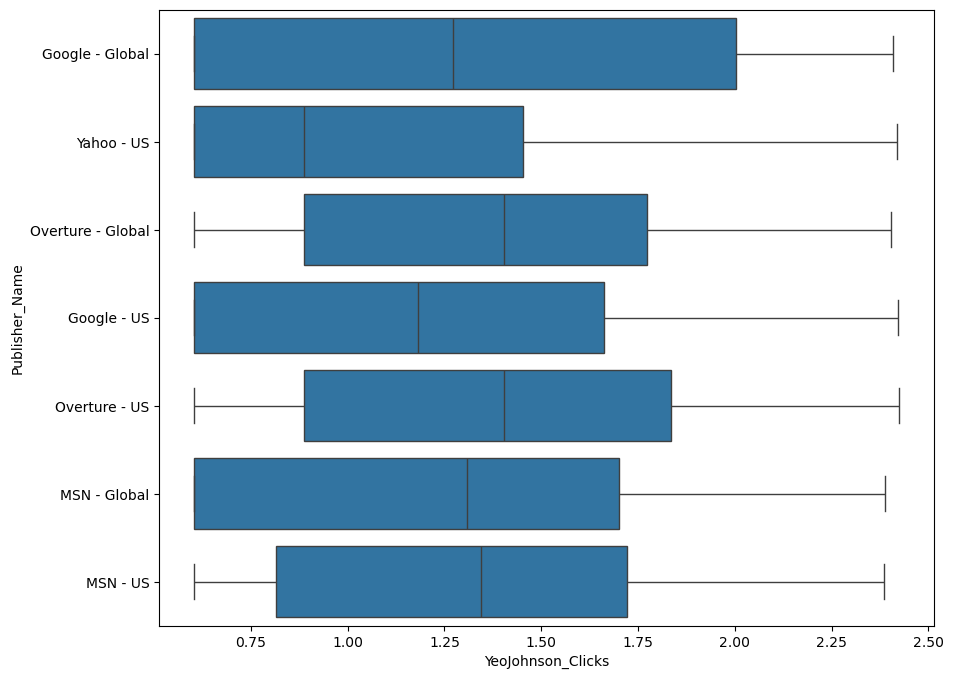

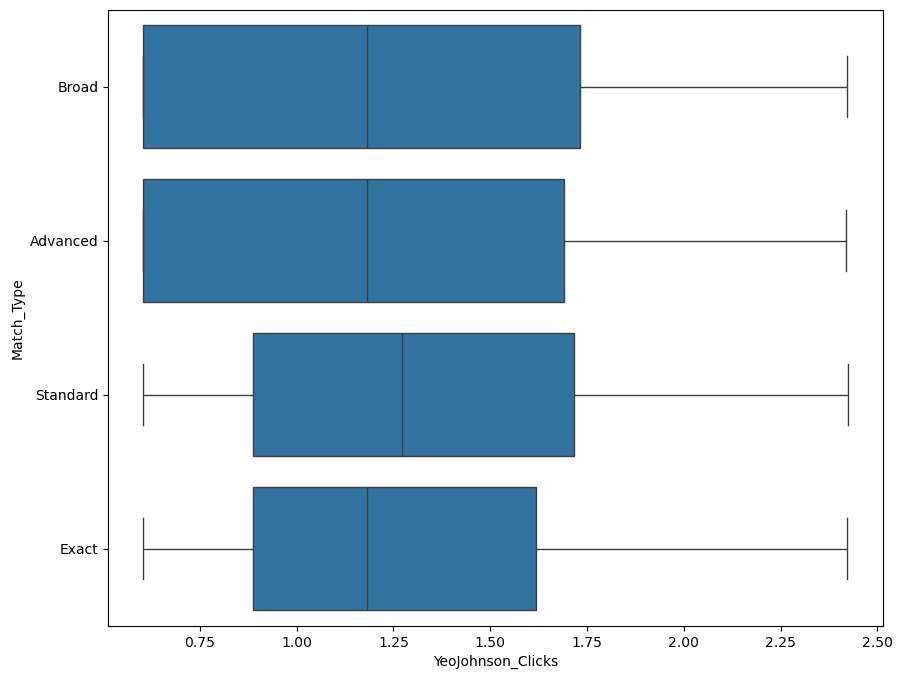

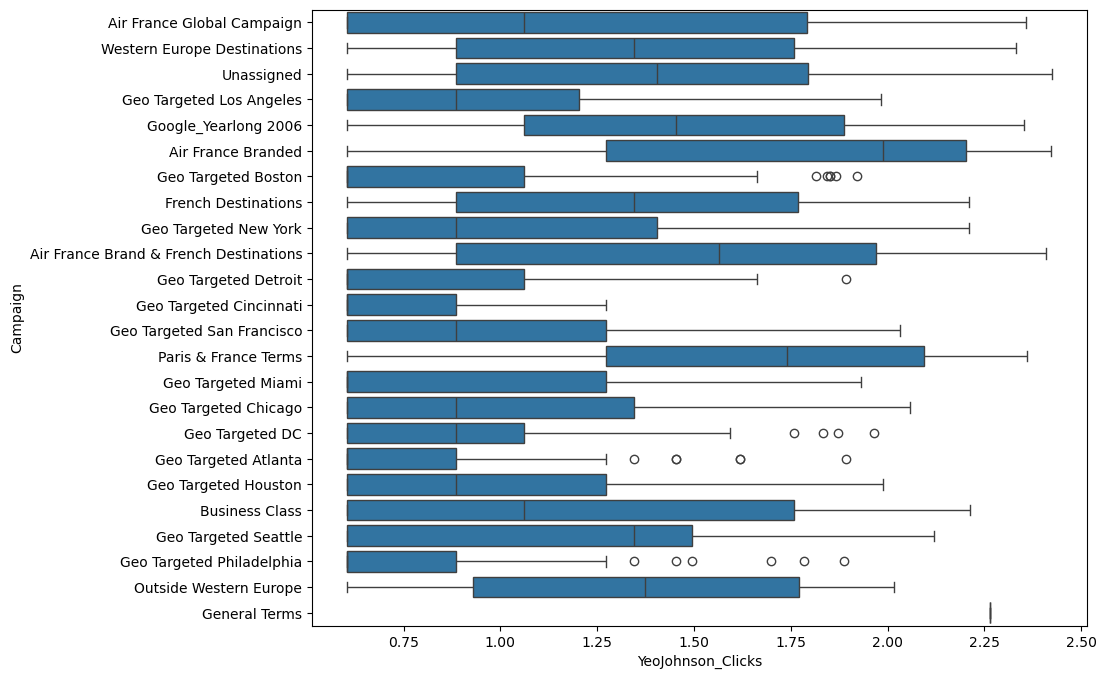

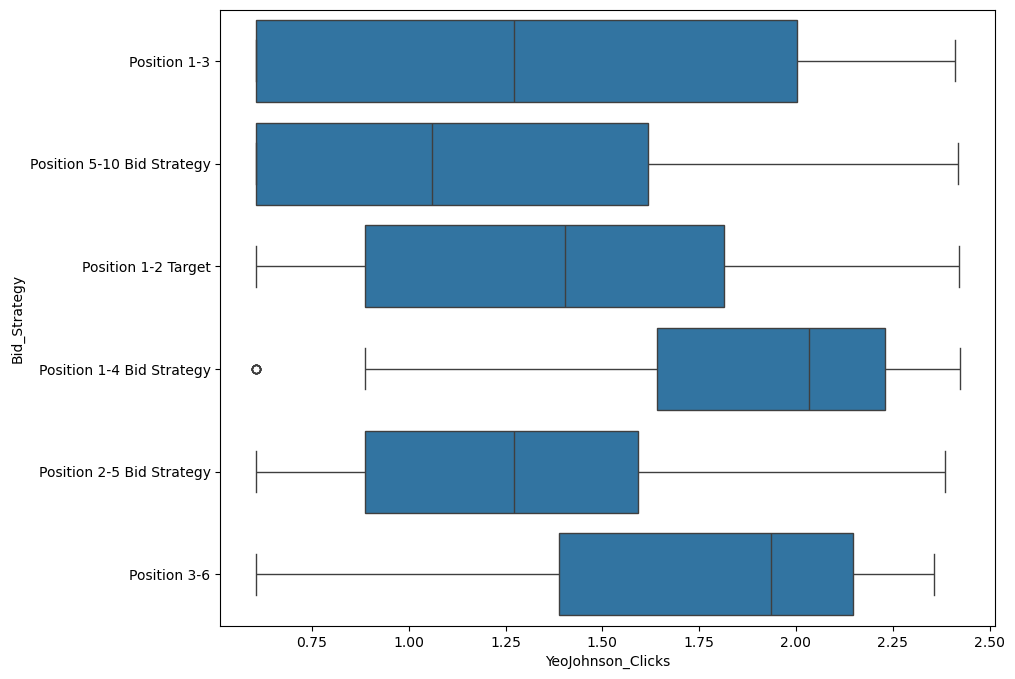

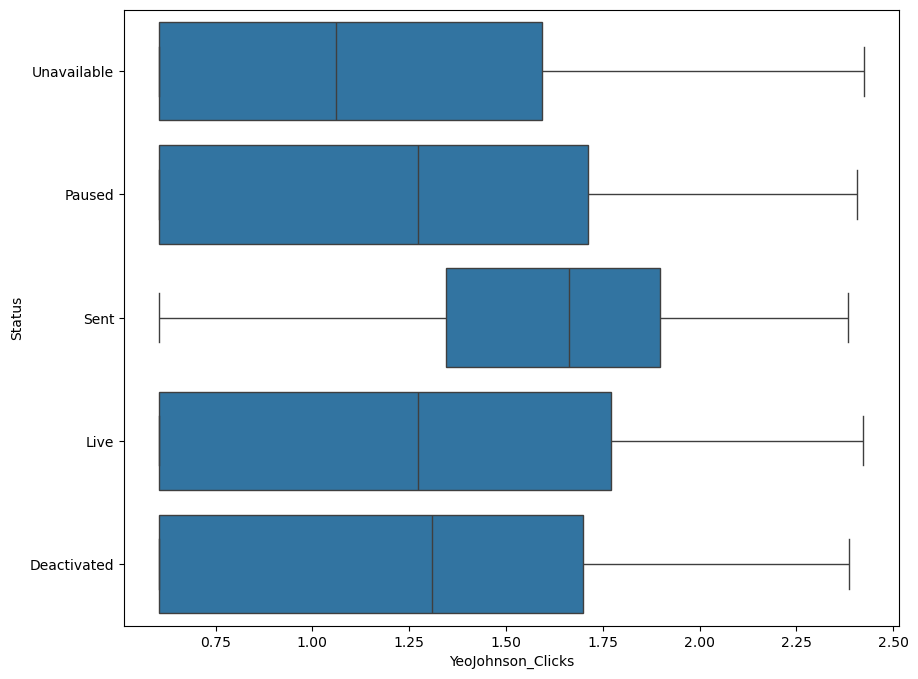

In [1174]:
# calling the function for Publisher_Name
categorical_boxplots(response = 'YeoJohnson_Clicks',
					 cat_var  = 'Publisher_Name',
					 data     = df_full)


# calling the function for Match_Type
categorical_boxplots(response = 'YeoJohnson_Clicks',
					 cat_var  = 'Match_Type',
					 data     = df_full)

# calling the function for Campaign
categorical_boxplots(response = 'YeoJohnson_Clicks',
					 cat_var  = 'Campaign',
					 data     = df_full)

# calling the function for Bid_Strategy
categorical_boxplots(response = 'YeoJohnson_Clicks',
					 cat_var  = 'Bid_Strategy',
					 data     = df_full)

# calling the function for Status
categorical_boxplots(response = 'YeoJohnson_Clicks',
					 cat_var  = 'Status',
					 data     = df_full)

In [1175]:
old_cat = ['Outside Western Europe', 'Geo Targeted Cincinnati', 'General Terms']

# Replacing
df_full['Campaign'] = df_full['Campaign'].replace(old_cat, 'Others')

In [1176]:
# one hot encoding categorical variables
one_hot_Publisher_Name = pd.get_dummies(df_full['Publisher_Name'])
one_hot_Match_Type = pd.get_dummies(df_full['Match_Type'])
one_hot_Campaign = pd.get_dummies(df_full['Campaign'])
one_hot_Bid_Strategy = pd.get_dummies(df_full['Bid_Strategy'])
one_hot_Bid_Status = pd.get_dummies(df_full['Status'])

# dropping categorical variables after they've been encoded
df_full = df_full.drop('Publisher_Name', axis = 1)
df_full = df_full.drop('Match_Type', axis = 1)
df_full = df_full.drop('Campaign', axis = 1)
df_full = df_full.drop('Bid_Strategy', axis = 1)
df_full = df_full.drop('Status', axis = 1)

# joining codings together
df_full = df_full.join([one_hot_Publisher_Name,one_hot_Match_Type,one_hot_Campaign,one_hot_Bid_Strategy,one_hot_Bid_Status])


# saving new columns
new_columns = df_full.columns

In [1177]:
# New feature: impression_bid
df_full['Impressions_Bid'] = df_full['Impressions'] * df_full['Search_Engine_Bid']
# New feature: AvgPos_Bid
df_full['AvgPos_Bid'] = df_full['Avg_Pos'] * df_full['Search_Engine_Bid']

import pandas as pd

# Define ranges for 'Avg. Pos.'
bins = [0, 1, 2, 3, 4, 5, float('inf')]
labels = ['1st', '2nd', '3rd', '4th', '5th', 'Above 5th']

# New feature: AvgPos_Category
df_full['AvgPos_Category'] = pd.cut(df_full['Avg_Pos'], bins=bins, labels=labels, include_lowest=True)


In [1178]:
#Now, we are going to clean the keywords from special characters
def clean_keyword(keyword):
    # Delete special characters
    keyword_clean = re.sub(r'[^a-zA-Z0-9\s]', ' ', str(keyword))
    # Lowercase transformation
    keyword_clean = keyword_clean.lower()
    return keyword_clean

# Applying the function to 'Keyword' column
df_full['Keyword_Cleaned'] = df_full['Keyword'].apply(clean_keyword)

# Checking the dataset
df_full[['Keyword', 'Keyword_Cleaned']].tail(100)

,Keyword,Keyword_Cleaned
entry_id,,
mkt_4036,flight to nice,flight to nice
mkt_2533,air france,air france
mkt_4114,[air france],air france
mkt_3635,air france com,air france com
mkt_1937,cheap flight to europe,cheap flight to europe
mkt_3304,air france italy,air france italy
mkt_278,airfrance com,airfrance com
mkt_896,flights to paris,flights to paris
mkt_912,france airline,france airline


In [1179]:
df_full['Keyword_Length'] = df_full['Keyword_Cleaned'].apply(len)

In [1180]:
#Downloading stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jorgeluissolis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [1181]:
#  Initialize the TF-IDF vectorizer with optional parameters
tfidf_vectorizer = TfidfVectorizer(max_features=1000,stop_words=stopwords.words('english'))  # Puedes ajustar 'max_features' según sea necesario
tfidf_matrix = tfidf_vectorizer.fit_transform(df_full['Keyword_Cleaned'])

# Converting in dataframe
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Checking the dataframe
tfidf_df.head()

,2006,abidjan,abou,aeroport,affaires,agadir,agen,agency,agent,air,airfare,airfares,airframce,airfrance,airline,airlines,airplane,airplanetickets,airport,airports,airway,ajaccio,amman,amsterdam,angeles,anger,arrival,athenes,athens,atlanta,avignon,aviv,avn,bamako,bangalore,bangui,barcelona,bargain,basel,bastia,beauvais,bed,belgrade,bergerac,berlin,best,bologna,book,booking,bora,bordeaux,boston,brest,britain,broad,brussels,bucarest,bucharest,budapest,budget,business,buy,ca,caen,cairo,calais,campaign,cannes,carcassonne,casablanca,cdg,charles,cheap,cheapest,chennai,chicago,cincinnati,city,class,clermont,co,cologne,com,conakry,cont,copenhagen,cost,cotonou,cruises,customer,dakar,damascus,day,dc,de,deal,deals,deauville,degaulle,delhi,destination,detroit,dhabi,diego,dijon,direct,discount,discounted,djibouti,dubai,dusseldorf,england,espace,europe,european,exact,express,fair,family,fare,fares,ferrand,first,flat,flight,flights,florence,fly,fr,franc,france,francisco,frankfurt,french,frequence,frequency,gaulle,general,geneva,genoa,geo,germany,getaway,glasgow,global,google,gothenburg,great,greece,greek,grenoble,guide,hamburg,hanover,helsinki,holiday,holidays,home,hotel,houston,idea,india,info,information,international,istanbul,italy,jfk,johannesburg,kiev,krakow,la,lax,le,lille,limoges,line,lisbon,lom,london,lorient,los,lourdes,low,lowest,luxury,lyon,madrid,malaga,man,manchester,marrakech,marseille,marseilles,miami,milan,montpellier,moscow,mulhouse,mumbai,munich,nairobi,nantes,naples,new,newark,nice,nimes,nouakchott,number,nuremberg,ny,nyc,offer,online,orange,orlando,orly,oslo,ouagadougou,overseas,page,par,paris,perpignan,petersburg,philadelphia,phoenix,phone,pisa,place,plain,plan,plane,planning,plus,poitiers,prague,price,prices,pricing,promotion,rabat,rate,reims,relaunch,rennes,reservation,rochelle,rodez,roissy,romance,romantic,rome,round,sale,sales,san,schedule,search,seat,service,seville,site,sofia,south,southampton,southern,spain,special,specials,split,spot,st,stockholm,strasbourg,stuttgart,switzerland,system,tahiti,targeted,tel,ticket,ticketing,tickets,tiket,timetable,tou,toulon,toulouse,tour,toure,tourism,tourist,tours,travel,trip,trips,tunis,turin,turkey,uk,us,usa,vacation,vacations,valencia,venice,vienna,visit,warsaw,warsow,washington,web,webpage,website,welcome,xpress,yaound,yearlong,york,zagreb,zurich
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.726331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.687345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [1182]:
#Merging the tfidf_df dataset with the df_full dataset
tfidf_df.index = df_full.index
df_full = pd.concat([df_full,tfidf_df], axis=1)
df_full = df_full.drop('Keyword', axis = 1)
df_full = df_full.drop('Keyword_Cleaned', axis = 1)

In [1183]:
#Encoding the column 'Category' using the Clicks means
mean_encoding = df_full.groupby('Category')['Clicks'].mean()
df_full['Category'] = df_full['Category'].map(mean_encoding)

In [1184]:
#Encoding the column 'Keyword_Group' using the Clicks means
mean_encoding_keyword_group = df_full.groupby('Keyword_Group')['Clicks'].mean()
df_full['Keyword_Group'] = df_full['Keyword_Group'].map(mean_encoding_keyword_group)


In [1189]:
# one hot encoding categorical variables
one_hot_AvgPos_Category = pd.get_dummies(df_full['AvgPos_Category'])

# dropping categorical variables after they've been encoded
df_full = df_full.drop('AvgPos_Category', axis = 1)

In [1190]:
# creating a (Pearson) correlation matrix
df_corr = df_full.corr(numeric_only = True).round(2)


# printing (Pearson) correlations with Clicks
df_corr.loc[ : , ['Clicks', 'log_Clicks', 'YeoJohnson_Clicks'] ].sort_values(by = 'Clicks',
                                                                ascending = False)

,Clicks,log_Clicks,YeoJohnson_Clicks
Clicks,1.00,0.36,0.19
Impressions_Bid,0.43,0.17,0.09
Impressions,0.40,0.19,0.10
log_Clicks,0.36,1.00,0.94
Keyword_Group,0.25,0.31,0.25
Air France Branded,0.24,0.17,0.11
log_Impressions,0.24,0.80,0.80
boxcox_Impressions,0.22,0.78,0.79
YeoJohnson_Impressions,0.22,0.78,0.80
Category,0.21,0.11,0.09


<br><h3>Standardization</h3>

In [1191]:
## Standardization ##

# preparing explanatory variable data
df_full_data   = df_full.drop(['Clicks',
                               'log_Clicks',
                               'YeoJohnson_Clicks',
                                'set'],
                                axis = 1)



# preparing the target variable
df_full_target = df_full.loc[ : , ['Clicks',
                               'log_Clicks', 'YeoJohnson_Clicks',
                                   'set']]

In [1192]:
# INSTANTIATING a StandardScaler() object
scaler = StandardScaler()


# FITTING the scaler with the data
scaler.fit(df_full_data)


# TRANSFORMING our data after fit
x_scaled = scaler.transform(df_full_data)


# converting scaled data into a DataFrame
x_scaled_df = pd.DataFrame(x_scaled)


# checking the results
x_scaled_df.describe(include = 'number').round(decimals = 2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385
count,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.0,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,4510.00,

In [1193]:
# adding labels to the scaled DataFrame

#x_scaled_df = pd.DataFrame(x_scaled_df, index=df_full_data.index, columns=df_full_data.columns)
x_scaled_df.columns = df_full_data.columns
#  Checking pre- and post-scaling of the data
print(f"""
Dataset BEFORE Scaling
----------------------
{np.var(df_full_data)}


Dataset AFTER Scaling
----------------------
{np.var(x_scaled_df)}
""")


Dataset BEFORE Scaling
----------------------
Keyword_Group                             6.681934e+04
Category                                  4.795161e+04
Search_Engine_Bid                         1.089910e+01
Impressions                               2.878065e+10
Avg_Pos                                   1.156514e+00
Avg_Cost_per_Click                        1.748281e+00
m_Match_Type                              1.052974e-02
m_Bid_Strategy                            1.977406e-01
log_Impressions                           6.008358e+00
log_Avg_Pos                               9.556233e-02
log_Avg_Cost_per_Click                    1.974737e-01
YeoJohnson_Impressions                    3.665024e+00
YeoJohnson_Avg_Pos                        5.808277e-03
YeoJohnson_Avg_Cost_per_Click             1.689804e-01
boxcox_Impressions                        4.929961e+00
has_Search_Engine_Bid                     4.799858e-02
Google - Global                           7.954636e-02
Google - US       

/Users/jorgeluissolis/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3745: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/jorgeluissolis/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3745: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [1194]:
x_scaled_df.index = df_full_target.index
df_full = pd.concat([x_scaled_df, df_full_target], axis=1)
df_full.head()

,Keyword_Group,Category,Search_Engine_Bid,Impressions,Avg_Pos,Avg_Cost_per_Click,m_Match_Type,m_Bid_Strategy,log_Impressions,log_Avg_Pos,log_Avg_Cost_per_Click,YeoJohnson_Impressions,YeoJohnson_Avg_Pos,YeoJohnson_Avg_Cost_per_Click,boxcox_Impressions,has_Search_Engine_Bid,Google - Global,Google - US,MSN - Global,MSN - US,Overture - Global,Overture - US,Yahoo - US,Advanced,Broad,Exact,Standard,Air France Brand & French Destinations,Air France Branded,Air France Global Campaign,Business Class,French Destinations,Geo Targeted Atlanta,Geo Targeted Boston,Geo Targeted Chicago,Geo Targeted DC,Geo Targeted Detroit,Geo Targeted Houston,Geo Targeted Los Angeles,Geo Targeted Miami,Geo Targeted New York,Geo Targeted Philadelphia,Geo Targeted San Francisco,Geo Targeted Seattle,Google_Yearlong 2006,Others,Paris & France Terms,Unassigned,Western Europe Destinations,Position 1-2 Target,Position 1-3,Position 1-4 Bid Strategy,Position 2-5 Bid Strategy,Position 3-6,Position 5-10 Bid Strategy,Deactivated,Live,Paused,Sent,Unavailable,Impressions_Bid,AvgPos_Bid,Keyword_Length,2006,abidjan,abou,aeroport,affaires,agadir,agen,agency,agent,air,airfare,airfares,airframce,airfrance,airline,airlines,airplane,airplanetickets,airport,airports,airway,ajaccio,amman,amsterdam,angeles,anger,arrival,athenes,athens,atlanta,avignon,aviv,avn,bamako,bangalore,bangui,barcelona,bargain,basel,bastia,beauvais,bed,belgrade,bergerac,berlin,best,bologna,book,booking,bora,bordeaux,boston,brest,britain,broad,brussels,bucarest,bucharest,budapest,budget,business,buy,ca,caen,cairo,calais,campaign,cannes,carcassonne,casablanca,cdg,charles,cheap,cheapest,chennai,chicago,cincinnati,city,class,clermont,co,cologne,com,conakry,cont,copenhagen,cost,cotonou,cruises,customer,dakar,damascus,day,dc,de,deal,deals,deauville,degaulle,delhi,destination,detroit,dhabi,diego,dijon,direct,discount,discounted,djibouti,dubai,dusseldorf,england,espace,europe,european,exact,express,fair,family,fare,fares,ferrand,first,flat,flight,flights,florence,fly,fr,franc,france,francisco,frankfurt,french,frequence,frequency,gaulle,general,geneva,genoa,geo,germany,getaway,glasgow,global,google,gothenburg,great,greece,greek,grenoble,guide,hamburg,hanover,helsinki,holiday,holidays,home,hotel,houston,idea,india,info,information,international,istanbul,italy,jfk,johannesburg,kiev,krakow,la,lax,le,lille,limoges,line,lisbon,lom,london,lorient,los,lourdes,low,lowest,luxury,lyon,madrid,malaga,man,manchester,marrakech,marseille,marseilles,miami,milan,montpellier,moscow,mulhouse,mumbai,munich,nairobi,nantes,naples,new,newark,nice,nimes,nouakchott,number,nuremberg,ny,nyc,offer,online,orange,orlando,orly,oslo,ouagadougou,overseas,page,par,paris,perpignan,petersburg,philadelphia,phoenix,phone,pisa,place,plain,plan,plane,planning,plus,poitiers,prague,price,prices,pricing,promotion,rabat,rate,reims,relaunch,rennes,reservation,rochelle,rodez,roissy,romance,romantic,rome,round,sale,sales,san,schedule,search,seat,service,seville,site,sofia,south,southampton,southern,spain,special,specials,split,spot,st,stockholm,strasbourg,stuttgart,switzerland,system,tahiti,targeted,tel,ticket,ticketing,tickets,tiket,timetable,tou,toulon,toulouse,tour,toure,tourism,tourist,tours,travel,trip,trips,tunis,turin,turkey,uk,us,usa,vacation,vacations,valencia,venice,vienna,visit,warsaw,warsow,washington,web,webpage,website,welcome,xpress,yaound,yearlong,york,zagreb,zurich,Clicks,log_Clicks,YeoJohnson_Clicks,set
entry_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
mkt_001,-0.323419,-0.387522,-1.267635,-0.052482,-0.074134,-0.711573,-0.103718,-0.610319,0.315368,0.081574,-0.663867,0.369042,0.285955,-0.654414,0.356035,

<br><hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>

<h2>Part III: Data Partitioning</h2>

<h3>Separating the Kaggle Data</h3><br>

In [1195]:
## parsing out testing data (needed for later) ##

# dataset for kaggle
kaggle_data = df_full[ df_full['set'] == 'Kaggle' ].copy()


# dataset for model building
df = df_full[ df_full['set'] == 'Not Kaggle' ].copy()


# dropping set identifier (kaggle)
kaggle_data.drop(labels = 'set',
                 axis = 1,
                 inplace = True)


# dropping set identifier (model building)
df.drop(labels = 'set',
        axis = 1,
        inplace = True)

In [1197]:
# Excluding columns
exclude_columns = ['Clicks','YeoJohnson_Clicks','YeoJohnson_Impressions','boxcox_Impressions','Impressions']


# Choosing my x_features
x_features = [column for column in df.columns if column not in exclude_columns]
x_features

['Keyword_Group',
 'Category',
 'Search_Engine_Bid',
 'Avg_Pos',
 'Avg_Cost_per_Click',
 'm_Match_Type',
 'm_Bid_Strategy',
 'log_Impressions',
 'log_Avg_Pos',
 'log_Avg_Cost_per_Click',
 'YeoJohnson_Avg_Pos',
 'YeoJohnson_Avg_Cost_per_Click',
 'has_Search_Engine_Bid',
 'Google - Global',
 'Google - US',
 'MSN - Global',
 'MSN - US',
 'Overture - Global',
 'Overture - US',
 'Yahoo - US',
 'Advanced',
 'Broad',
 'Exact',
 'Standard',
 'Air France Brand & French Destinations',
 'Air France Branded',
 'Air France Global Campaign',
 'Business Class',
 'French Destinations',
 'Geo Targeted Atlanta',
 'Geo Targeted Boston',
 'Geo Targeted Chicago',
 'Geo Targeted DC',
 'Geo Targeted Detroit',
 'Geo Targeted Houston',
 'Geo Targeted Los Angeles',
 'Geo Targeted Miami',
 'Geo Targeted New York',
 'Geo Targeted Philadelphia',
 'Geo Targeted San Francisco',
 'Geo Targeted Seattle',
 'Google_Yearlong 2006',
 'Others',
 'Paris & France Terms',
 'Unassigned',
 'Western Europe Destinations',
 'Posit

<br><h3>Train-Test Split</h3><br>
Note that the following code will remove non-numeric features, keeping only integer and float data types. It will also remove any observations that contain missing values. This is to prevent errors in the model building process. 

In [1198]:
#!###########################!#
#!# choose your x-variables #!#
#!###########################!#
x_features = ['log_Impressions','Keyword_Group',
 'Category','Impressions_Bid', 'Air France Branded','Exact','Keyword_Length','Position 5-10 Bid Strategy',
 'Search_Engine_Bid','Impressions','log_Avg_Cost_per_Click', 'YeoJohnson_Avg_Pos','Broad','air','airfrance',
              'travel','Standard','Position 1-4 Bid Strategy','flight','flights','france','paris','Clicks'] 
# this should be a list



## ########################### ##
## DON'T CHANGE THE CODE BELOW ##
## ########################### ##

# removing non-numeric columns and missing values
df = df[x_features].copy().select_dtypes(include=[int, float]).dropna(axis = 0)


# prepping data for train-test split
x_data = df.drop(labels = y_variable,
                 axis   = 1)

y_data = df[y_variable]


# train-test split (to validate the model)
x_train, x_test, y_train, y_test = train_test_split(x_data, 
                                                    y_data, 
                                                    test_size    = 0.25,
                                                    random_state = 702 )


# results of train-test split
print(f"""
Original Dataset Dimensions
---------------------------
Observations (Rows): {df.shape[0]}
Features  (Columns): {df.shape[1]}


Training Data (X-side)
----------------------
Observations (Rows): {x_train.shape[0]}
Features  (Columns): {x_train.shape[1]}


Training Data (y-side)
----------------------
Feature Name:        {y_train.name}
Observations (Rows): {y_train.shape[0]}


Testing Data (X-side)
---------------------
Observations (Rows): {x_test.shape[0]}
Features  (Columns): {x_test.shape[1]}


Testing Data (y-side)
---------------------
Feature Name:        {y_test.name}
Observations (Rows): {y_test.shape[0]}""")


Original Dataset Dimensions
---------------------------
Observations (Rows): 4410
Features  (Columns): 23


Training Data (X-side)
----------------------
Observations (Rows): 3307
Features  (Columns): 22


Training Data (y-side)
----------------------
Feature Name:        Clicks
Observations (Rows): 3307


Testing Data (X-side)
---------------------
Observations (Rows): 1103
Features  (Columns): 22


Testing Data (y-side)
---------------------
Feature Name:        Clicks
Observations (Rows): 1103


<hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>

<h2>Part III: Candidate Modeling</h2>

In [1199]:
## Candidate Modeling ##

#!###########################!#
#!# choose your x-variables #!#
#!###########################!#
# naming the model
model_name = "Pruned Regression Tree" # name your model

# model type
model = DecisionTreeRegressor(max_depth = 4,
                              min_samples_leaf = 25,
                              random_state = 702) # model type ( ex: sklearn.linear_model.LinearRegression() )



## ########################### ##
## DON'T CHANGE THE CODE BELOW ##
## ########################### ##

# FITTING to the training data
model_fit = model.fit(x_train, y_train)


# PREDICTING on new data
model_pred = model.predict(x_test)


# SCORING the results
model_train_score = model.score(x_train, y_train).round(4)
model_test_score  = model.score(x_test, y_test).round(4)
model_gap         = abs(model_train_score - model_test_score).round(4)
# Calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test, model_pred))
    

# dynamically printing results
model_summary =  f"""\
Model Name:     {model_name}
Train_Score:    {model_train_score}
Test_Score:     {model_test_score}
Train-Test Gap: {model_gap}
RMSE:           {rmse}
"""

print(model_summary)

Model Name:     Pruned Regression Tree
Train_Score:    0.3301
Test_Score:     0.0894
Train-Test Gap: 0.2407
RMSE:           510.15885228698704



In [1200]:
# Getting feature importances
feature_importances = model.feature_importances_
feature_names = x_train.columns
# Sort feature names by importance
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_feature_importances = [feature_importances[i] for i in sorted_indices]
print("Feature Importances:")
for name, importance in zip(sorted_feature_names, sorted_feature_importances):
    print(f"{name}: Importance {importance:.4f}")

Feature Importances:
Impressions_Bid: Importance 0.9068
log_Impressions: Importance 0.0817
Keyword_Group: Importance 0.0116
france: Importance 0.0000
Category: Importance 0.0000
Air France Branded: Importance 0.0000
Exact: Importance 0.0000
Keyword_Length: Importance 0.0000
Position 5-10 Bid Strategy: Importance 0.0000
Search_Engine_Bid: Importance 0.0000
Impressions: Importance 0.0000
paris: Importance 0.0000
YeoJohnson_Avg_Pos: Importance 0.0000
Broad: Importance 0.0000
air: Importance 0.0000
airfrance: Importance 0.0000
travel: Importance 0.0000
Standard: Importance 0.0000
Position 1-4 Bid Strategy: Importance 0.0000
flight: Importance 0.0000
flights: Importance 0.0000
log_Avg_Cost_per_Click: Importance 0.0000


In [1268]:
## Candidate Modeling ##

#!###########################!#
#!# choose your x-variables #!#
#!###########################!#
# naming the model
model_name = "Gradient Boosting" # name your model

# model type
model = GradientBoostingRegressor(n_estimators=390, 
                                  learning_rate=0.1,
                                  max_depth=3,  
                                  min_samples_leaf=25, 
                                  random_state=702)   # model type ( ex: sklearn.linear_model.LinearRegression() )



## ########################### ##
## DON'T CHANGE THE CODE BELOW ##
## ########################### ##

# FITTING to the training data
model_fit = model.fit(x_train, y_train)


# PREDICTING on new data
model_pred = model.predict(x_test)


# SCORING the results
model_train_score = model.score(x_train, y_train).round(4)
model_test_score  = model.score(x_test, y_test).round(4)
model_gap         = abs(model_train_score - model_test_score).round(4)
# Calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test, model_pred))
    

# dynamically printing results
model_summary =  f"""\
Model Name:     {model_name}
Train_Score:    {model_train_score}
Test_Score:     {model_test_score}
Train-Test Gap: {model_gap}
RMSE:           {rmse}
"""

print(model_summary)

Model Name:     Gradient Boosting
Train_Score:    0.7959
Test_Score:     0.6153
Train-Test Gap: 0.1806
RMSE:           331.5624701767656



In [1206]:
## Candidate Modeling ##

#!###########################!#
#!# choose your x-variables #!#
#!###########################!#
# naming the model
model_name = "Elastic Net (scaled) with MSE" # name your model

# model type
model = sklearn.linear_model.SGDRegressor(alpha = 0.5,
                                          penalty = 'elasticnet',
                                         random_state = 702) # model type ( ex: sklearn.linear_model.LinearRegression() )



## ########################### ##
## DON'T CHANGE THE CODE BELOW ##
## ########################### ##

# FITTING to the training data
model_fit = model.fit(x_train, y_train)


# PREDICTING on new data
model_pred = model.predict(x_test)

# Calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test, model_pred))
# SCORING the results
model_train_score = model.score(x_train, y_train).round(4)
model_test_score  = model.score(x_test, y_test).round(4)
model_gap         = abs(model_train_score - model_test_score).round(4)
    

# dynamically printing results
model_summary =  f"""\
Model Name:     {model_name}
Train_Score:    {model_train_score}
Test_Score:     {model_test_score}
Train-Test Gap: {model_gap}
RMSE:           {rmse}
"""

print(model_summary)

Model Name:     Elastic Net (scaled) with MSE
Train_Score:    0.2313
Test_Score:     0.5067
Train-Test Gap: 0.2754
RMSE:           375.4851232528534



In [1207]:
## Candidate Modeling ##

#!###########################!#
#!# choose your x-variables #!#
#!###########################!#
# naming the model
model_name = "Ridge (scaled)" # name your model

# model type
model = sklearn.linear_model.Ridge(alpha = 10.0,
                                   random_state = 702) # model type ( ex: sklearn.linear_model.LinearRegression() )



## ########################### ##
## DON'T CHANGE THE CODE BELOW ##
## ########################### ##

# FITTING to the training data
model_fit = model.fit(x_train, y_train)


# PREDICTING on new data
model_pred = model.predict(x_test)


# SCORING the results
model_train_score = model.score(x_train, y_train).round(4)
model_test_score  = model.score(x_test, y_test).round(4)
model_gap         = abs(model_train_score - model_test_score).round(4)
# Calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test, model_pred))    

# dynamically printing results
model_summary =  f"""\
Model Name:     {model_name}
Train_Score:    {model_train_score}
Test_Score:     {model_test_score}
Train-Test Gap: {model_gap}
RMSE:           {rmse}
"""

print(model_summary)

Model Name:     Ridge (scaled)
Train_Score:    0.347
Test_Score:     0.1785
Train-Test Gap: 0.1685
RMSE:           484.54018673368756



In [1208]:
## Candidate Modeling ##

#!###########################!#
#!# choose your x-variables #!#
#!###########################!#
# naming the model
model_name = "Lasso (scaled)" # name your model

# model type
model = sklearn.linear_model.Lasso(alpha       = 1.0,
                                  random_state = 702) # model type ( ex: sklearn.linear_model.LinearRegression() )



## ########################### ##
## DON'T CHANGE THE CODE BELOW ##
## ########################### ##

# FITTING to the training data
model_fit = model.fit(x_train, y_train)


# PREDICTING on new data
model_pred = model.predict(x_test)


# SCORING the results
model_train_score = model.score(x_train, y_train).round(4)
model_test_score  = model.score(x_test, y_test).round(4)
model_gap         = abs(model_train_score - model_test_score).round(4)
# Calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test, model_pred)) 
    

# dynamically printing results
model_summary =  f"""\
Model Name:     {model_name}
Train_Score:    {model_train_score}
Test_Score:     {model_test_score}
Train-Test Gap: {model_gap}
RMSE:           {rmse}
"""

print(model_summary)

Model Name:     Lasso (scaled)
Train_Score:    0.3476
Test_Score:     0.1842
Train-Test Gap: 0.1634
RMSE:           482.87056094408985



In [1212]:
## Candidate Modeling ##

#!###########################!#
#!# choose your x-variables #!#
#!###########################!#
# naming the model
model_name = "KNN" # name your model

# model type
model = KNeighborsRegressor(algorithm = 'auto',
                   n_neighbors = 5) # model type ( ex: sklearn.linear_model.LinearRegression() )



## ########################### ##
## DON'T CHANGE THE CODE BELOW ##
## ########################### ##

# FITTING to the training data
model_fit = model.fit(x_train, y_train)


# PREDICTING on new data
model_pred = model.predict(x_test)


# SCORING the results
model_train_score = model.score(x_train, y_train).round(4)
model_test_score  = model.score(x_test, y_test).round(4)
model_gap         = abs(model_train_score - model_test_score).round(4)
# Calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test, model_pred))     

# dynamically printing results
model_summary =  f"""\
Model Name:     {model_name}
Train_Score:    {model_train_score}
Test_Score:     {model_test_score}
Train-Test Gap: {model_gap}
RMSE:           {rmse}
"""

print(model_summary)

Model Name:     KNN
Train_Score:    0.4952
Test_Score:     0.7661
Train-Test Gap: 0.2709
RMSE:           258.53134298130493



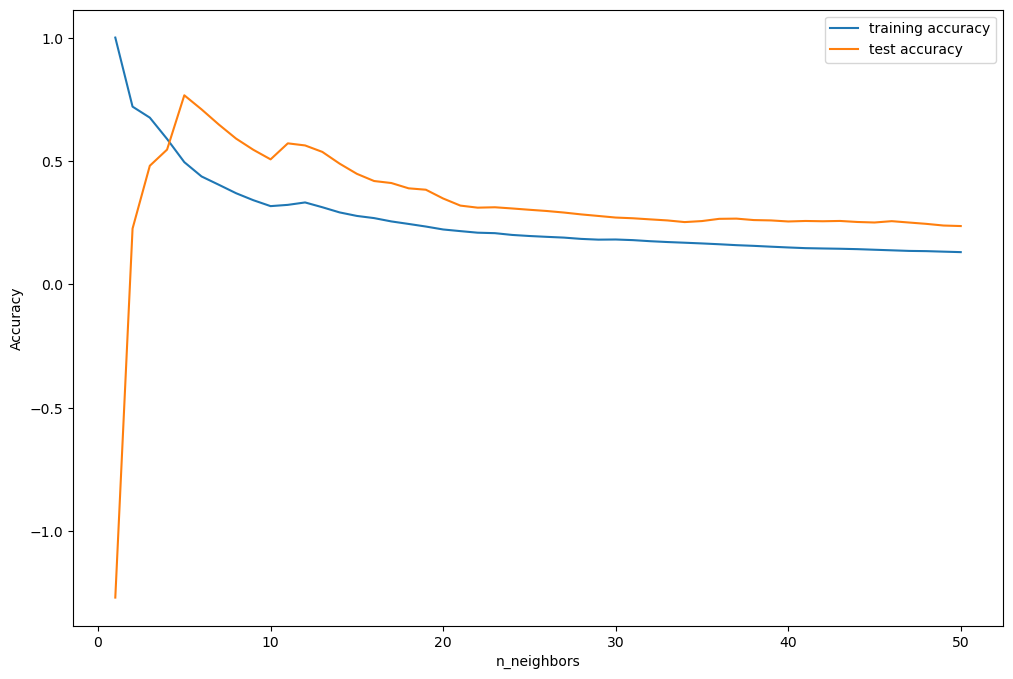

In [1210]:
# creating lists for training set accuracy and test set accuracy
training_accuracy = []
test_accuracy     = []


# building a visualization of 1 to 50 neighbors
neighbors_settings = range(1, 51)


for n_neighbors in neighbors_settings:
    # Building the model
    clf = KNeighborsRegressor(n_neighbors = n_neighbors)
    clf.fit(x_train, y_train)
    
    # Recording the training set accuracy
    training_accuracy.append(clf.score(x_train, y_train))
    
    # Recording the generalization accuracy
    test_accuracy.append(clf.score(x_test, y_test))


# plotting the visualization
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(neighbors_settings, training_accuracy, label = "training accuracy")
plt.plot(neighbors_settings, test_accuracy, label = "test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.show()

In [1211]:
# finding the optimal number of neighbors
opt_neighbors = test_accuracy.index(max(test_accuracy)) + 1
print(f"""The optimal number of neighbors is {opt_neighbors}""")

The optimal number of neighbors is 5


In [1215]:
## Candidate Modeling ##

#!###########################!#
#!# choose your x-variables #!#
#!###########################!#
# naming the model
model_name = "Random Forest" # name your model

# model type
model = RandomForestRegressor(n_estimators=100,
                              random_state=702) # model type ( ex: sklearn.linear_model.LinearRegression() )



## ########################### ##
## DON'T CHANGE THE CODE BELOW ##
## ########################### ##

# FITTING to the training data
model_fit = model.fit(x_train, y_train)


# PREDICTING on new data
model_pred = model.predict(x_test)


# SCORING the results
model_train_score = model.score(x_train, y_train).round(4)
model_test_score  = model.score(x_test, y_test).round(4)
model_gap         = abs(model_train_score - model_test_score).round(4)
# Calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test, model_pred))
    

# dynamically printing results
model_summary =  f"""\
Model Name:     {model_name}
Train_Score:    {model_train_score}
Test_Score:     {model_test_score}
Train-Test Gap: {model_gap}
RMSE:           {rmse}
"""

print(model_summary)

Model Name:     Random Forest
Train_Score:    0.9257
Test_Score:     -1.8925
Train-Test Gap: 2.8182
RMSE:           909.222146524663



In [540]:
#Getting parameters
params_used = model.get_params()

# Print parameters
print("Parameters:")
for param, value in params_used.items():
    print(f"{param}: {value}")

Parameters:
bootstrap: True
ccp_alpha: 0.0
criterion: squared_error
max_depth: None
max_features: 1.0
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: 702
verbose: 0
warm_start: False


In [1216]:
## Candidate Modeling ##

#!###########################!#
#!# choose your x-variables #!#
#!###########################!#
# naming the model
model_name = "MLPRegressor" # name your model

# model type
model = MLPRegressor(hidden_layer_sizes=(100, 50),
                     activation        ='relu',
                     solver            ='adam',
                     random_state      =702) # model type ( ex: sklearn.linear_model.LinearRegression() )



## ########################### ##
## DON'T CHANGE THE CODE BELOW ##
## ########################### ##

# FITTING to the training data
model_fit = model.fit(x_train, y_train)


# PREDICTING on new data
model_pred = model.predict(x_test)


# SCORING the results
model_train_score = model.score(x_train, y_train).round(4)
model_test_score  = model.score(x_test, y_test).round(4)
model_gap         = abs(model_train_score - model_test_score).round(4)
# Calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test, model_pred))
    

# dynamically printing results
model_summary =  f"""\
Model Name:     {model_name}
Train_Score:    {model_train_score}
Test_Score:     {model_test_score}
Train-Test Gap: {model_gap}
RMSE:           {rmse}
"""

print(model_summary)

Model Name:     MLPRegressor
Train_Score:    0.8158
Test_Score:     -0.1371
Train-Test Gap: 0.9529
RMSE:           570.0746100346057



/Users/jorgeluissolis/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<br>
<h3>Hyperparameter Tuning</h3><br>

In [1217]:
## Hyperparameter Tuning ##
# declaring a hyperparameter space
criterion_range = ["squared_error", "friedman_mse", "absolute_error", "poisson"]
splitter_range  = ["best", "random"]
depth_range     = np.arange(1,11,1)
leaf_range      = np.arange(0,25,5)

# creating a hyperparameter grid
param_grid = {'criterion'      : criterion_range,
             'splitter'        : splitter_range,
             'max_depth'       : depth_range,
             'min_samples_leaf': leaf_range}
              


# INSTANTIATING the model object without hyperparameters
tuned_tree = DecisionTreeRegressor()


# RandomizedSearchCV object
tuned_tree_cv = RandomizedSearchCV(estimator             = tuned_tree, #model
                                   param_distributions   = param_grid, #hyperparameter ranges
                                   cv                    = 5,    #folds
                                   n_iter                = 10, #how many models to build
                                   random_state          = 702)


# FITTING to the FULL DATASET (due to cross-validation)
tuned_tree_cv.fit(x_data, y_data)


# printing the optimal parameters and best score
print("Tuned Parameters  :", tuned_tree_cv.best_params_)
print("Tuned Training AUC:", tuned_tree_cv.best_score_.round(4))

/Users/jorgeluissolis/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 400 is smaller than n_iter=1000. Running 400 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/jorgeluissolis/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
400 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
400 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jorgeluissolis/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/

Tuned Parameters  : {'splitter': 'random', 'min_samples_leaf': 5, 'max_depth': 8, 'criterion': 'absolute_error'}
Tuned Training AUC: 0.4849


In [1218]:
# naming the model
model_name = 'Tuned Tree'


model = DecisionTreeRegressor(splitter         = 'random',
                              min_samples_leaf = 5,
                              max_depth        = 8,
                              criterion        = 'absolute_error')


# FITTING to the TRAINING data
model.fit(x_train, y_train)


# PREDICTING based on the testing set
model.predict(x_test)


# SCORING results
model_train_score = model.score(x_train, y_train).round(4)
model_test_score  = model.score(x_test, y_test).round(4)
model_gap         = abs(model_train_score - model_test_score).round(4)
# Calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test, model_pred))

# displaying results
print('Training Score :', model_train_score)
print('Testing Score  :', model_test_score)
print('Train-Test Gap :', model_gap)
print('RMSE           :',rmse)

Training Score : 0.3222
Testing Score  : 0.5355
Train-Test Gap : 0.2133
RMSE           : 570.0746100346057


In [1219]:
## Hyperparameter Tuning ##
# declaring a hyperparameter space
learning_rate_range = np.linspace(0.01, 0.2, 20) # Experimenta con diferentes rangos y valores
n_estimators_range = np.arange(100, 1000, 100)
max_depth_range = np.arange(3, 10, 1)
min_samples_split_range = np.arange(2, 10, 1)
min_samples_leaf_range = np.arange(1, 10, 1)
max_features_range = ['auto', 'sqrt', 'log2', None]



# creating a hyperparameter grid
param_grid = {'learning_rate': learning_rate_range,
                'n_estimators': n_estimators_range,
                'max_depth': max_depth_range,
                'min_samples_split': min_samples_split_range,
                'min_samples_leaf': min_samples_leaf_range,
                'max_features': max_features_range}
              


# INSTANTIATING the model object without hyperparameters
tuned_gbr = GradientBoostingRegressor()


# RandomizedSearchCV object
tuned_gbr_cv = RandomizedSearchCV(estimator             = tuned_gbr, #model
                                   param_distributions   = param_grid, #hyperparameter ranges
                                   cv                    = 5,    #folds
                                   n_iter                = 10, #how many models to build
                                   random_state          = 702)


# FITTING to the FULL DATASET (due to cross-validation)
tuned_gbr_cv.fit(x_data, y_data)


# printing the optimal parameters and best score
print("Tuned Parameters  :", tuned_gbr_cv.best_params_)
print("Tuned Training AUC:", tuned_gbr_cv.best_score_.round(4))

/Users/jorgeluissolis/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jorgeluissolis/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jorgeluissolis/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/jorgeluissolis/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_pa

Tuned Parameters  : {'n_estimators': 900, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 3, 'learning_rate': 0.16}
Tuned Training AUC: 0.6038


In [1288]:
# naming the model
model_name = 'Gradient Boosting'


model = GradientBoostingRegressor(learning_rate=0.16,
                n_estimators= 900,
                max_depth=3,
                min_samples_split=9,
                min_samples_leaf=2,
                max_features='log2')


# FITTING to the TRAINING data
model.fit(x_train, y_train)


# PREDICTING based on the testing set
model.predict(x_test)


# SCORING results
model_train_score = model.score(x_train, y_train).round(4)
model_test_score  = model.score(x_test, y_test).round(4)
model_gap         = abs(model_train_score - model_test_score).round(4)
# Calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test, model_pred))

# displaying results
print('Training Score :', model_train_score)
print('Testing Score  :', model_test_score)
print('Train-Test Gap :', model_gap)
print('RMSE           :',rmse)

Training Score : 0.9997
Testing Score  : -0.7108
Train-Test Gap : 1.7105
RMSE           : 331.5624701767656


In [351]:
## Hyperparameter Tuning ##
# declaring a hyperparameter space
hidden_layer_sizes_range = [(50,), (100,), (100, 50)]
activation_range = ['relu']
solver_range = ['adam']
alpha_range = [0.0001, 0.001, 0.01]
learning_rate_range = ['constant', 'invscaling']
max_iter_range = [100, 200, 300]

# creating a hyperparameter grid
param_grid = {'hidden_layer_sizes': hidden_layer_sizes_range,
              'activation': activation_range,
              'solver': solver_range,
              'alpha': alpha_range,
              'learning_rate': learning_rate_range,
              'max_iter': max_iter_range}
              


# INSTANTIATING the model object without hyperparameters
mlp_reg = MLPRegressor()


# RandomizedSearchCV object
mlp_reg_cv = RandomizedSearchCV(estimator             = mlp_reg, #model
                                   param_distributions   = param_grid, #hyperparameter ranges
                                   cv                    = 5,    #folds
                                   n_iter                = 5,
                                   n_jobs                =-1,
                                   random_state          = 702)


# FITTING to the FULL DATASET (due to cross-validation)
mlp_reg_cv.fit(x_data, y_data)


# printing the optimal parameters and best score
print("Tuned Parameters  :", mlp_reg_cv.best_params_)
print("Tuned Training AUC:", mlp_reg_cv.best_score_.round(4))

/Users/jorgeluissolis/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jorgeluissolis/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jorgeluissolis/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jorgeluissolis/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Tuned Parameters  : {'solver': 'adam', 'max_iter': 200, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (100, 50), 'alpha': 0.01, 'activation': 'relu'}
Tuned Training AUC: 0.4359


/Users/jorgeluissolis/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [352]:
# naming the model
model_name = 'MLPRegressor'


model = MLPRegressor(hidden_layer_sizes=(100, 50),
                      activation='relu',
                      solver= 'adam',
                      alpha=0.01,
                      learning_rate= 'invscaling',
                      max_iter= 200)


# FITTING to the TRAINING data
model.fit(x_train, y_train)


# PREDICTING based on the testing set
model.predict(x_test)


# SCORING results
model_train_score = model.score(x_train, y_train).round(4)
model_test_score  = model.score(x_test, y_test).round(4)
model_gap         = abs(model_train_score - model_test_score).round(4)
# Calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test, model_pred))

# displaying results
print('Training Score :', model_train_score)
print('Testing Score  :', model_test_score)
print('Train-Test Gap :', model_gap)
print('RMSE           :',rmse)

Training Score : 0.646
Testing Score  : -0.1807
Train-Test Gap : 0.8267
RMSE           : 611.8893094718208


/Users/jorgeluissolis/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [1291]:
#Best Model
# naming the model
#model_name = 'Gradient Boosting'

#The parameters are:
#model = GradientBoostingRegressor(learning_rate=0.16,
 #               n_estimators= 900,
  #              max_depth=3,
   #             min_samples_split=9,
    #            min_samples_leaf=2,
     #           max_features='log2')



## Candidate Model Development and Final Model Selection

For the development of the predictive model, we experimented with various regression algorithms, from Gradient Boosting to decision trees, each offering distinct advantages and differing prediction levels. Gradient Boosting stood out for its ability to sequentially correct errors from previous trees, demonstrating its high effectiveness in working with our comprehensive and feature-rich dataset. On the other hand, MLPRegressor, a type of neural network, offered some flexibility in capturing nonlinear relationships but required meticulous tuning to avoid overfitting. Decision trees provided a simple and interpretable model structure but were prone to overfitting.

For model construction, our evaluation criteria encompassed predictive accuracy, measured by RMSE (Root Mean Squared Error), and the model's ability to predict new data, i.e., generalize. We also used cross-validation considering computational efficiency and model interpretability. Gradient Boosting emerged as the best option due to its optimal balance between accuracy and generalization. Additionally, it provides feature importance analysis, offering insights into the attributes impacting the prediction of the target variable 'Clicks'. Decision trees, while highly interpretable, suffered from susceptibility to overfitting, reinforcing Gradient Boosting as the best prediction algorithm for this dataset.

Ultimately, the model relies on the importance of a robust preprocessing, cleaning, and judicious feature engineering process, which involves an iterative process of model tuning and validation to achieve a high level of predictability.

<hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>

<h2>Part IV: Preparing Submission File for Kaggle</h2><br>
The code below will store the predicted values for each of the models above.

In [1289]:
# removing non-numeric columns and missing values
kaggle_df = kaggle_data[x_features].copy()


# x-data
x_data_kaggle = kaggle_df.drop(labels = y_variable,
                               axis   = 1)

# y-data
y_data_kaggle = kaggle_df[y_variable]


# Fitting model from above to the Kaggle test data
kaggle_predictions = model.predict(x_data_kaggle)

<br>
<h3>Creating the Kaggle File</h3><br>

In [1293]:
## Kaggle Submission File ##

# organizing predictions
model_predictions = {"Clicks" : kaggle_predictions}


# converting predictions into df
model_pred_df = pd.DataFrame(data  = model_predictions,
                             index = df_test.index)


,Clicks
entry_id,
mkt_4036,161.803986
mkt_2533,7582.839762
mkt_4114,6323.246992
mkt_3635,470.829708
mkt_1937,581.143462


In [1294]:
model_pred_df = np.floor(model_pred_df)
model_pred_df.head()

,Clicks
entry_id,
mkt_4036,161.0
mkt_2533,7582.0
mkt_4114,6323.0
mkt_3635,470.0
mkt_1937,581.0


In [1295]:
#!######################!#
#!# name the .csv file #!#
#!######################!#

# sending predictions to .csv
model_pred_df.to_csv(path_or_buf = "./model_output/Team_9_A2_v5.csv",
                     index       = True,
                     index_label = 'entry_id')